### Лабораторная работа № 4
### Сети с радиальными базисными элементами

`Цель работы:` исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

Выполнил: Семин А. В., М8О-406Б-20

Вариант 21.

Импортируем библиотеки

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Задание 1

Определим три группы точек (эллипсы и парабола с поворотом)

In [2]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

def parabola(t, p, x0, y0):
    x = x0 + t ** 2 / (2. * p)
    y = y0 + t
    return x, y

def rotate(x, y, alpha):
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

Зададим отрезок и коэффициенты фигур

In [3]:
t = np.linspace(0, 2 * np.pi, 200)

# Эллипс: a = 0.5, b = 0.2, α = π/3, x0 = 0, y0 = 0
x1_fig, y1_fig = ellipse(t, a=0.5, b=0.2, x0=0., y0=0.)
x1, y1 = rotate(x1_fig, y1_fig, np.pi / 3.)

# Эллипс: a = 0.7, b = 0.7, α = 0, x0 = 0.08, y0 = 0.05
x2_fig, y2_fig = ellipse(t, a=0.7, b=0.7, x0=0.08, y0=0.05)
x2, y2 = rotate(x2_fig, y2_fig, 0.)

#Парабола: p = −1, α = −π/2, x0 = 0, y0 = −0.8
x3_fig, y3_fig = parabola(t, p=-1., x0=0., y0=-0.8)
x3, y3 = rotate(x3_fig, y3_fig, -np.pi / 2.)

In [4]:
points1 = [[x, y] for x, y in zip(x1, y1)]
points2 = [[x, y] for x, y in zip(x2, y2)]
points3 = [[x, y] for x, y in zip(x3, y3)]

classes1 = [[1., 0., 0.] for _ in range(len(points1))]
classes2 = [[0., 1., 0.] for _ in range(len(points2))]
classes3 = [[0., 0., 1.] for _ in range(len(points3))]

X = points1 + points2 + points3
y = classes1 + classes2 + classes3

И разделим данные на тренировочные и тестовые, сформируем тензоры

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
x_train = torch.FloatTensor(np.array(x_train))
y_train = torch.FloatTensor(np.array(y_train))

x_test = torch.FloatTensor(np.array(x_test))
y_test = torch.FloatTensor(np.array(y_test))

Для обучения нейросети сформируем батчи, потому что объем данных большой

In [7]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, int(len(train_dataset) * 0.1), shuffle=True)

Объявим класс сети радиально-базисных функций (РБФ). В качестве радиально-базисной функции используем функцию Гаусса. 

Общий алгоритм работы РБФ сети:
 - рассчет расстояний до центра;
 - применение нормировочной функции;
 - применение параметров формы;
 - применение радиально-базисной функции;
 - формирование линейной комибанции весов с результатами проведенных рассчетов.

In [4]:
class  RBFLayer(nn.Module):
    def __init__(self, in_features: int, num_kernels: int, out_features: int, upper_bound_kernels: float = 1.0, std_shapes: float = 0.1, gain_weights: float = 1.0):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.num_kernels = num_kernels 
        self.out_features = out_features
        self.weights = nn.Parameter(torch.zeros(self.out_features, self.num_kernels, dtype=torch.float32))
        self.kernels_centers = nn.Parameter(torch.zeros(self.num_kernels, self.in_features, dtype=torch.float32))
        self.log_shapes = nn.Parameter(torch.zeros(self.num_kernels, dtype=torch.float32))
        nn.init.uniform_(self.kernels_centers, a=-upper_bound_kernels, b=upper_bound_kernels)
        nn.init.normal_(self.log_shapes, mean=0.0, std=std_shapes)
        nn.init.xavier_uniform_(self.weights, gain=gain_weights)

    def forward(self, input: torch.Tensor):
        batch_size = input.size(0)
        centers_expanded  = self.kernels_centers.expand(batch_size, self.num_kernels, self.in_features)
        differences  = input.view(batch_size, 1, self.in_features) - centers_expanded
        distances  = l_norm(differences )
        eps_distances = self.log_shapes.exp().expand(batch_size, self.num_kernels) * distances 
        rbfs_res = rbf_gauss(eps_distances)
        res = self.weights.expand(batch_size, self.out_features, self.num_kernels) * rbfs_res.view(batch_size, 1, self.num_kernels)
        return res.sum(dim=-1)
    
def l_norm(x, p=2):
    return torch.norm(x, p=p, dim=-1)

def rbf_gauss(x):
    return torch.exp(-x.pow(2))

Нейросеть на вход принимает два признака - координаты, а на выходе выдает три значения в промежутке `[0, 1]`, чтобы их можно было интерпретировать как RGB для дальнейшего отображения предсказаний нейросети в виде цветовой схемы. 
Функцию потерь выберем MSE.

In [9]:
rbf_classifier = RBFLayer(2, 10, 3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(rbf_classifier.parameters())

Определим функцию предсказания

In [12]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Определим функцию обучения

In [8]:
def fit(model, train_loader, criterion, optimizer, epochs):
    train_losses = []
    running_loss = 0.0
    total_samples_processed = 0

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()*inputs.size(0)
            total_samples_processed += inputs.size(0)

        average_loss  = running_loss / total_samples_processed
        train_losses .append(average_loss )
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch:03d} | Train Loss: {average_loss :0.4f}\n')

    return train_losses 

Обучим модель на 2000 эпохах

In [12]:
losses = fit(rbf_classifier, train_loader, loss_function, optimizer, 2000)

Epoch 000 | Train Loss: 1.8430

Epoch 100 | Train Loss: 0.4155

Epoch 200 | Train Loss: 0.2915

Epoch 300 | Train Loss: 0.2444

Epoch 400 | Train Loss: 0.2186

Epoch 500 | Train Loss: 0.2016

Epoch 600 | Train Loss: 0.1833

Epoch 700 | Train Loss: 0.1651

Epoch 800 | Train Loss: 0.1510

Epoch 900 | Train Loss: 0.1398

Epoch 1000 | Train Loss: 0.1308

Epoch 1100 | Train Loss: 0.1234

Epoch 1200 | Train Loss: 0.1171

Epoch 1300 | Train Loss: 0.1117

Epoch 1400 | Train Loss: 0.1069

Epoch 1500 | Train Loss: 0.1025

Epoch 1600 | Train Loss: 0.0986

Epoch 1700 | Train Loss: 0.0952

Epoch 1800 | Train Loss: 0.0921

Epoch 1900 | Train Loss: 0.0893



Посмотрим на график функции потерь (MSE) между исходными и вычисленными данными

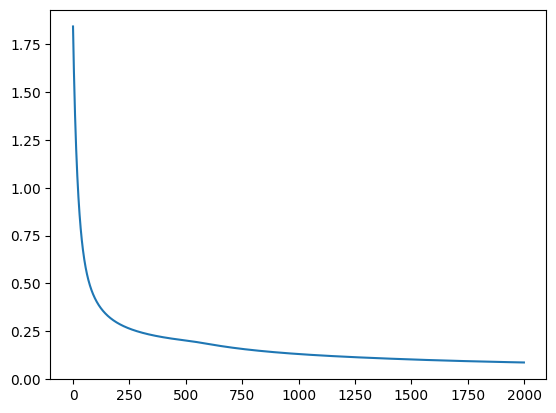

In [13]:
plt.plot(losses)
plt.show()

Отобразим исходные данные классов

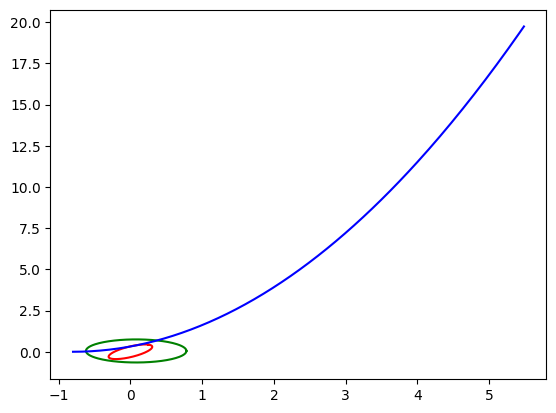

In [14]:
plt.plot(x1, y1, c = 'r')
plt.plot(x2, y2, c = 'g')
plt.plot(x3, y3, c = 'b')
plt.show()

Вычислим и отобразим предсказания модели для принадлежности каждой точки из области х =`[-18, 1]` , y=`[-1, 6]` одному из трех классов. Причем классы изначально линейно неразделимы

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


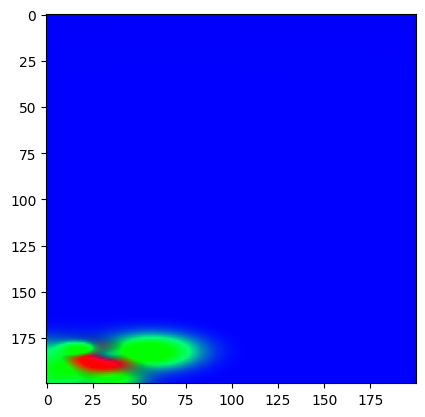

In [15]:
x_test = [[x, y] for x in np.linspace(-18, 1, 200) for y in np.linspace(-1, 6, 200)]

x_test = torch.FloatTensor(np.array(x_test))

prediction = predict(rbf_classifier, x_test)
prediction = prediction.reshape((200, 200, 3))

plt.imshow(prediction)
plt.show()

### Задание 2

Теперь перейдем к задаче аппроксимации функции. Создадим разреженную дискретную версию нашей исходной функции и будем использовать ее для обучения, чтобы потом получить при увеличенни шага приближение исходной функции

In [2]:
def function(t):
   return np.sin(t**2 - 10*t + 3)

In [3]:
t1 = np.linspace(1,6, 300)
f1 = function(t1)

t2 = np.linspace(1,6, 2000)
f2 = function(t2)

x_train2 = torch.FloatTensor(t1).view(-1, 1)
y_train2 = torch.FloatTensor(f1).view(-1, 1)
train_dataset2 = TensorDataset(x_train2, y_train2)

x_test2 = torch.FloatTensor(t2).view(-1, 1)

Наша сеть будет принимать на вход один признак, координату x, а на выходе будет выдавать значение функции в этой точке. 
Аналогично, функция потерь - MSE, оптимизатор - Adam.

In [5]:
rbf_approx = RBFLayer(1, 50, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(rbf_approx.parameters())

Будем обучать нашу сеть батчами размера `batch_size`, так как данных уже довольно много

In [6]:
batch_size = 10
train_loader2 = DataLoader(train_dataset2, batch_size)

Обучим модель

In [9]:
losses2 = fit(rbf_approx, train_loader2, loss_function, optimizer, 2500)

Epoch 000 | Train Loss: 0.5533

Epoch 100 | Train Loss: 0.3783

Epoch 200 | Train Loss: 0.3743

Epoch 300 | Train Loss: 0.3726

Epoch 400 | Train Loss: 0.3714

Epoch 500 | Train Loss: 0.3703

Epoch 600 | Train Loss: 0.3686

Epoch 700 | Train Loss: 0.3647

Epoch 800 | Train Loss: 0.3589

Epoch 900 | Train Loss: 0.3525

Epoch 1000 | Train Loss: 0.3456

Epoch 1100 | Train Loss: 0.3390

Epoch 1200 | Train Loss: 0.3330

Epoch 1300 | Train Loss: 0.3276

Epoch 1400 | Train Loss: 0.3227

Epoch 1500 | Train Loss: 0.3182

Epoch 1600 | Train Loss: 0.3141

Epoch 1700 | Train Loss: 0.3103

Epoch 1800 | Train Loss: 0.3068

Epoch 1900 | Train Loss: 0.3036

Epoch 2000 | Train Loss: 0.3005

Epoch 2100 | Train Loss: 0.2978

Epoch 2200 | Train Loss: 0.2953

Epoch 2300 | Train Loss: 0.2929

Epoch 2400 | Train Loss: 0.2908



Посмотрим на график функции потерь, вычисляющей `MSE` между исходными и полученными данными

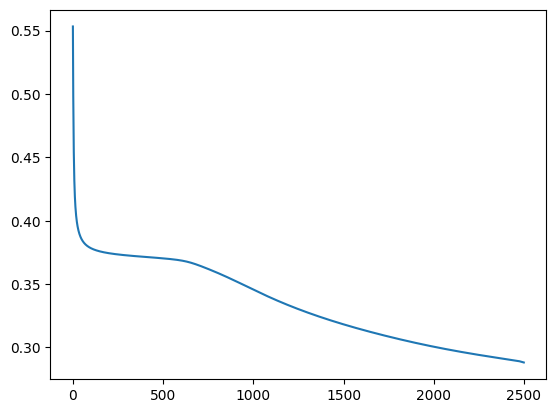

In [10]:
plt.plot(losses2)
plt.show()

Соберем предсказанные моделью значения функции

In [13]:
f2_pred = predict(rbf_approx, x_test2)

Отобразим полученные результаты и сравним предсказанную аппроксимацию и истинные значения функции 

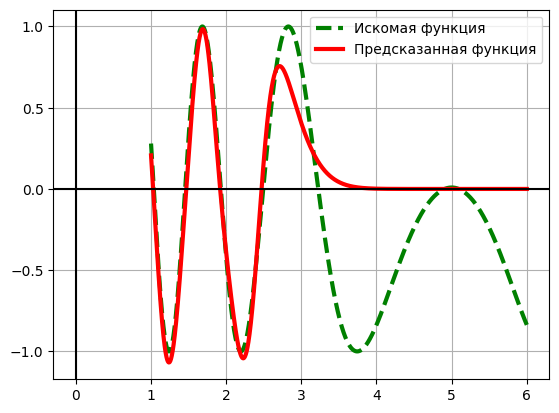

In [14]:
plt.plot(t2, f2, color="green", label='Искомая функция', linestyle='--', linewidth=3)
plt.plot(t2, f2_pred, color="red", label='Предсказанная функция', linewidth=3)

plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

`Выводы:` в ходе данной работы была построена сеть основанная на радиально-базисной функции, которая была использована для решения задач: классификации линейно неразделимых данных и аппроксимации функции.

Обучение сети на 2500 эпохах позволило получить хорошие результаты, причем ошибка на протяжении всего обучения падала стремительно.